## Dependencies

In [1]:
%load_ext tensorboard

In [1]:
import os
import numpy as np
from sklearn.model_selection import KFold
from ipynb.fs.full.Dataset_Construction_Isolated import construct_dataset
import matplotlib.pyplot as plt
import matplotlib.image as plt_img

import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import datetime

from zipfile import ZipFile 

2025-03-05 09:53:50.181403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741164830.247414     530 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741164830.267523     530 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 09:53:50.423940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## GPU Check

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Parameters

In [2]:
name = "TestCNN"
epochs = 10
steps = 50
batch = 40

## Making directory for CNN

In [ ]:
try:
    os.mkdir("CNN/" + name)
except:
    pass

try:
    os.mkdir("CNN/" + name + "/Tensorboard_Data")
except:
    pass

try:
    os.mkdir("CNN/" + name + "/Tensorboard_Data/Acc")
    os.mkdir("CNN/" + name + "/Tensorboard_Data/Loss")
except:
    pass

## Load constructed dataset

In [3]:
lst = os.listdir() 
if ("mushroom_dataset_x.npy" not in lst) or ("mushroom_dataset_y.npy" not in lst):
    print("Dataset files not found, contructing...")
    dataset_x, dataset_y = construct_dataset()
else:
    print("Dataset files found, loading...")
    dataset_x = np.load("mushroom_dataset_x.npy")
    dataset_y = np.load("mushroom_dataset_y.npy")
    print("Done")

Dataset files found, loading...
Done


## CNN Training

### Create and train Model with n folds

In [ ]:
kf = KFold(n_splits=10, shuffle=True)
kf_split = kf.split(dataset_x)
acc_array = []

for i, (train_index, val_index) in enumerate(kf_split):

    pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(227, 227, 3),
    name="resnet50",
    )

    for layer in pretrained_model.layers[:100]:
        layer.trainable = False

    
    cnn = models.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    layers.Dense(1, activation="sigmoid")
    ])
    
    cnn.compile(optimizer="SGD", loss="binary_crossentropy",  metrics=["accuracy"])
    
    log_dir = "logs/fit/" + name + "-K" + str(i)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')
    history = cnn.fit(dataset_x[train_index], 
                      dataset_y[train_index], 
                      validation_data=(dataset_x[val_index], dataset_y[val_index]), 
                      epochs=epochs, 
                      steps_per_epoch=steps, 
                      callbacks=[tensorboard_callback])

    print("K = " + str(i))
    print("Accuracy  {:0.2f} %".format(history.history["accuracy"][-1] * 100))
    acc_array.append(history.history["accuracy"][-1])

### Find best K-group and average

In [9]:
max_acc = max(acc_array)
acc_array.index(max_acc)
avg_acc = sum(acc_array) / len(acc_array)

print("Average accuracy = {:0.2f} %".format(avg_acc * 100))
print("K group with best accuracy = " + str(acc_array.index(max_acc)))
print("Accuracy = {:0.2f} %".format(max_acc * 100))

Average accuracy = 99.04 %
K group with best accuracy = 2
Accuracy = 99.89 %


## Open Tensorboard

In [ ]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## CNN Evaluation

### Load final dataset

In [12]:
if "FinalTrainTestSet" not in os.listdir():
        print("Unzipping final dataset...")
        with ZipFile("FinalTrainTestSet.zip", 'r') as zObject: 
            zObject.extractall(path="FinalTrainTestSet")
        print("Done")
        
print("Loading train_x...")
ftrain_x = np.load("FinalTrainTestSet/train_x.npy")
print("Done")

print("Loading train_y...")
ftrain_y = np.load("FinalTrainTestSet/train_y.npy")
print("Done")

print("Loading test_x...")
ftest_x = np.load("FinalTrainTestSet/test_x.npy")
print("Done")

print("Loading test_y...")
ftest_y = np.load("FinalTrainTestSet/test_y.npy")
print("Done")

Loading train_x...
Done
Loading train_y...
Done
Loading test_x...
Done
Loading test_y...
Done


## Create and train model

In [13]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(227, 227, 3),
    name="resnet50",
    )

for layer in pretrained_model.layers[:75]:
    layer.trainable = False

    
cnn = models.Sequential([
    pretrained_model,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
    
cnn.compile(optimizer="SGD", loss="binary_crossentropy",  metrics=["accuracy"])

log_dir = "logs/fit/" + name + "-Final"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')

cnn.fit(ftrain_x, ftrain_y, epochs=epochs, steps_per_epoch=steps, callbacks=[tensorboard_callback])

#cnn.save("CNN/" + name + "/" + name + ".keras")

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.6239 - loss: 2.9860
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8238 - loss: 0.3819 
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9040 - loss: 0.2350
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9523 - loss: 0.1249
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9808 - loss: 0.0594
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9766 - loss: 0.0618
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9676 - loss: 0.0882
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9804 - loss: 0.0539
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 1.0000 - loss: 0.0060
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 1.0000 - loss: 0.0013    


## Open Tensorboard for train time

In [ ]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## Generate prediction set

In [14]:
pred_y = np.empty([200, 1])
meta = np.empty([1, 227, 227, 3])

for i in range(0, ftest_x.shape[0]):
    meta[0] = ftest_x[i]
    pred_value = cnn.predict(meta, verbose=0)[0][0]
    
    if pred_value > 0.5:
        pred = 1
    else:
        pred = 0
        
    pred_y[i] = pred

## Graph confusion matrix

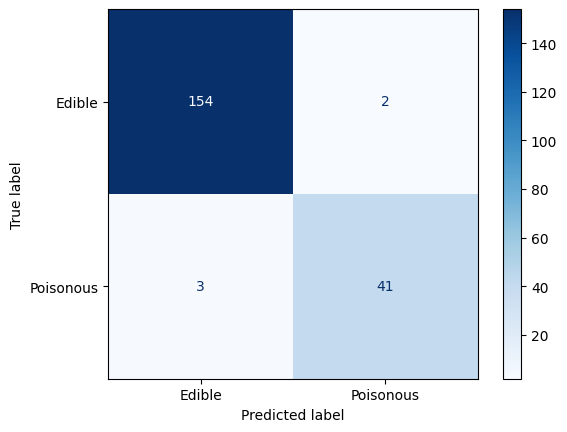

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(ftest_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap=plt.cm.Blues).figure_.savefig("CNN/" + name + "/" + name + "_ConfusionMatrix.svg")

## CNN Metrics

In [16]:
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (precision *  recall) / (precision + recall)
f1 *= 2

print(name + ":")
print("Accuracy  {:0.2f} %".format(accuracy * 100))
print("Precision {:0.2f} %".format(precision * 100))
print("Recall    {:0.2f} %".format(recall * 100))
print("F1        {:0.2f} %".format(f1 * 100))

ResNet50:
Accuracy  97.50 %
Precision 98.72 %
Recall    98.09 %
F1        98.40 %
